# Autoregressive Model for Explicit Density Estimation

In this approach, we model the likelihood directly, making the computation tractable by leveraging the chain rule to decompose the probability of a pixel $x_i$ into a conditional probability. The context for $x_i$ is provided by the preceding pixels. This conditional information is captured by a recurrent neural network (RNN) through its hidden state, which is passed forward in the sequence. The hidden state then serves as the context for predicting the next pixel value.

The probability of the data can be expressed as:
$$
p(x) = \prod_{i=1}^n p\left(x_i \mid x_1, \ldots, x_{i-1}\right)
$$

To reduce computational demands, I reformulated the problem as a sequence prediction task. Instead of using $(n \times m)$ images as instances, I generated sinusoidal patterns represented as vectors. These vectors have values constrained between 0 and 255 and a sequnce length of 16, simplifying the input space while maintaining the structure necessary for autoregressive modeling. Therefore instead of PixelRNN we are training a vanilla Long short-term memory (LSTM). These models are similar to RNNs but protect the integrity of the hidden state making the model more sensitive to long time series data. In this notebook you will complete code for a Dataset class, LSTM autoregressive class, and a training function. You can inspect your models performance visually simply by feeding the trained model and data instances into the given plotting function.

In [197]:
# Importing the libraries
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torch.utils.data import DataLoader, Dataset

In [198]:
# Generate sinusoidal data
def create_sinusoidal_dataset(num_samples=1000, vector_length=16, frequency=2):
    x = np.linspace(0, 2 * np.pi * frequency, vector_length)
    data = np.zeros((num_samples, vector_length), dtype=np.uint8)
    for i in range(num_samples):
        amplitude = np.random.uniform(50, 100)
        phase = np.random.uniform(0, 2 * np.pi)
        offset = np.random.uniform(100, 150)
        pattern = amplitude * np.sin(x + phase) + offset
        pattern = np.clip(pattern, 0, 255)
        data[i] = pattern.astype(np.uint8)
    return data

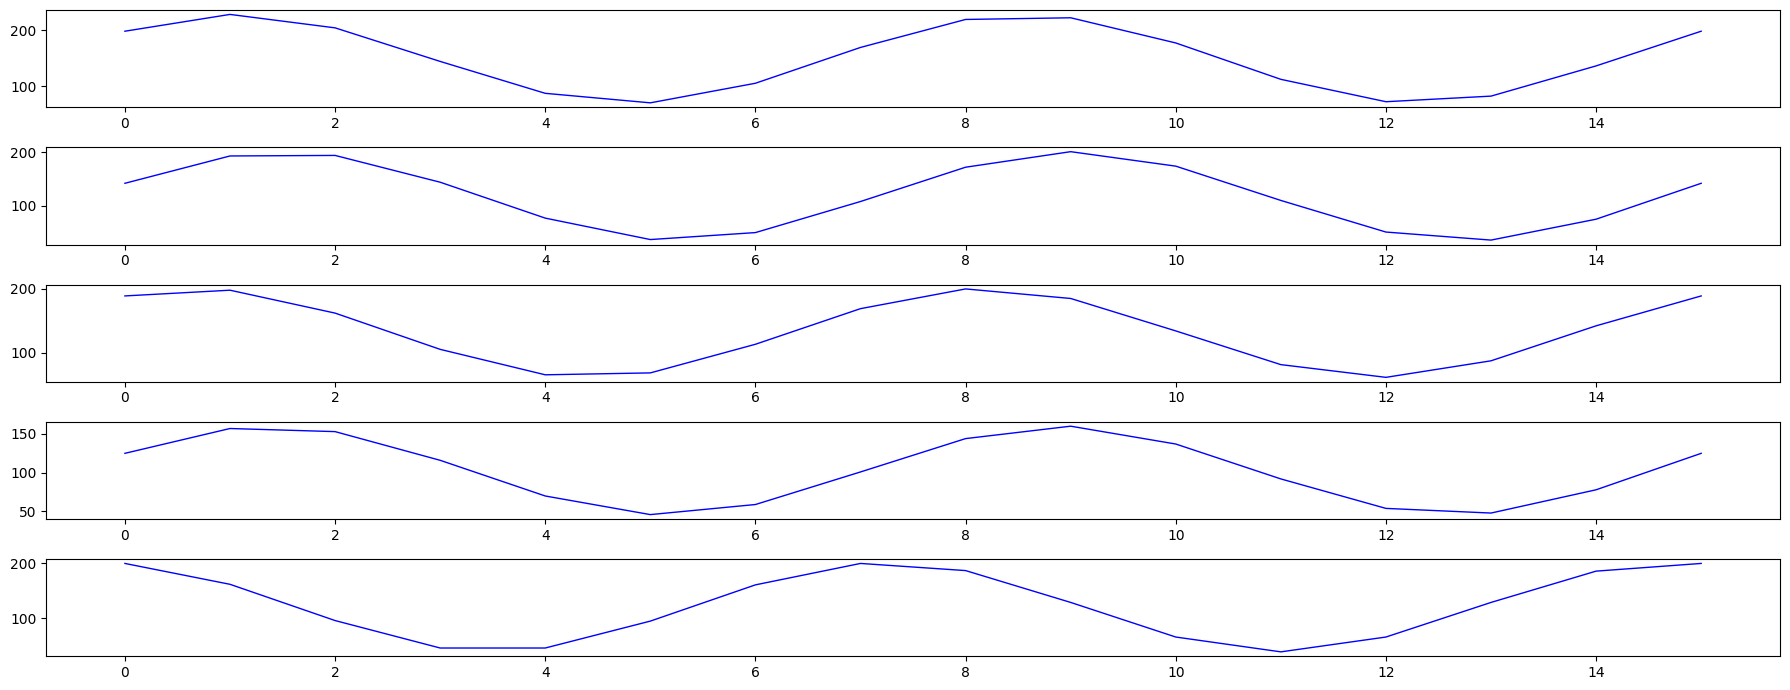

In [199]:
# Plot random samples of the data
data = create_sinusoidal_dataset()
plt.figure(figsize=(18, 7))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.plot(data[i], linewidth=1, color='blue')
plt.tight_layout()
plt.show()

In [200]:
data[0]

array([198, 228, 204, 144,  87,  70, 105, 169, 219, 222, 177, 112,  72,
        82, 136, 198], dtype=uint8)

In [201]:
# Create a custom Dataset class that loads the sinusoidal data and returns input-target pairs of type torch.float32
# The is the data generated by the create_sinusoidal_dataset function while the target is the same data shifted by one step
class SinusoidalDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        target = torch.cat((x[1:], x[:1]))
        return x, target

In [212]:
# Test your SinusoidalDataset class by running this code block
# # The block creates a dataset and dataloader using create_sinusoidal_dataset and the SinusoidalDataset class
# The output of the block should print torch.Size([1, 15]) torch.Size([1, 15]), and 15 pairs of input-target sequences offset by one step
data = create_sinusoidal_dataset(1, 16)
train_dataset = SinusoidalDataset(data)
train_loader = DataLoader(train_dataset, batch_size=1)
x, target = next(iter(train_loader))
print(x.shape, target.shape)
for i in range(x.size(1)):
    print(f'Input: {x[0, i].item():.2f} -> Target: {target[0, i].item():.2f}')

torch.Size([1, 16]) torch.Size([1, 16])
Input: 35.00 -> Target: 77.00
Input: 77.00 -> Target: 135.00
Input: 135.00 -> Target: 171.00
Input: 171.00 -> Target: 161.00
Input: 161.00 -> Target: 112.00
Input: 112.00 -> Target: 56.00
Input: 56.00 -> Target: 30.00
Input: 30.00 -> Target: 52.00
Input: 52.00 -> Target: 107.00
Input: 107.00 -> Target: 158.00
Input: 158.00 -> Target: 172.00
Input: 172.00 -> Target: 140.00
Input: 140.00 -> Target: 82.00
Input: 82.00 -> Target: 37.00
Input: 37.00 -> Target: 35.00
Input: 35.00 -> Target: 35.00


In [222]:
# Define the LSTM model
# The model should have an LSTM layer followed by a fully connected layer
# The fully connected layer should output one value at a time (the next value in the sequence)
# Remember to set batch_first=True in the LSTM layer
# And that lstms return two values, the output and the hidden state 
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        output = self.fc(output)  # output: (batch_size, seq_length, output_size)
        return output
        # return output[:, :, -1].unsqueeze(-1)

In [225]:
# The code block below tests the LSTMPredictor model by passing a random input tensor of shape (1, 15, 1) through the model
# The output shape should be (1, 15, 1)
model = LSTMPredictor(input_size=1, hidden_size=16, num_layers=1)
out = model(x.unsqueeze(-1))  # model takes input of shape (batch_size, seq_len, input_size)
print(out.shape)  # output shape: (batch_size, seq_len, 1) -> (1, 15, 1)

torch.Size([1, 16, 1])


In [226]:
# Set Hyperparameters
num_samples = 2000
vector_length = 16
batch_size = 32
input_size = 1
hidden_size = 64
num_layers = 1
num_epochs = 200
learning_rate = 0.001

In [228]:
# Create a function that trains the model
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0

        for inputs, targets in dataloader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)

            # Add extra dimension for single feature input
            inputs = inputs.unsqueeze(-1)
            targets = targets.unsqueeze(-1)

            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

In [229]:
# Create dataset and DataLoader
data = create_sinusoidal_dataset(num_samples, vector_length)
train_dataset = SinusoidalDataset(data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMPredictor(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch [1/200], Loss: 18201.5186
Epoch [2/200], Loss: 16775.3234
Epoch [3/200], Loss: 15422.2212
Epoch [4/200], Loss: 14365.6593
Epoch [5/200], Loss: 13409.5458
Epoch [6/200], Loss: 12582.6267
Epoch [7/200], Loss: 11830.6774
Epoch [8/200], Loss: 11145.1582
Epoch [9/200], Loss: 10500.0742
Epoch [10/200], Loss: 9894.5556
Epoch [11/200], Loss: 9340.6687
Epoch [12/200], Loss: 8824.1260
Epoch [13/200], Loss: 8333.2412
Epoch [14/200], Loss: 7881.3209
Epoch [15/200], Loss: 7462.3151
Epoch [16/200], Loss: 7063.2468
Epoch [17/200], Loss: 6701.6847
Epoch [18/200], Loss: 6346.8833
Epoch [19/200], Loss: 6004.1855
Epoch [20/200], Loss: 5691.9990
Epoch [21/200], Loss: 5403.7786
Epoch [22/200], Loss: 5123.0301
Epoch [23/200], Loss: 4855.5459
Epoch [24/200], Loss: 4599.9450
Epoch [25/200], Loss: 4357.4003
Epoch [26/200], Loss: 4121.8476
Epoch [27/200], Loss: 3885.0247
Epoch [28/200], Loss: 3660.4648
Epoch [29/200], Loss: 3459.7128
Epoch [30/200], Loss: 3261.0614
Epoch [31/200], Loss: 3077.9189
Epoch [3

In [230]:
# Use function as is to plot predictions and visualy inspect the model
def plot_predictions_with_context_shading(data, model, context_length, num_samples, device, fig_size=(10, 8)):
    """
    Plot original data and model predictions with grid background and shaded context region.

    Parameters:
        data (numpy array): Original dataset.
        model (torch.nn.Module): Trained RNN model.
        context_length (int): Length of context used for prediction.
        num_samples (int): Number of samples to visualize.
        device (torch.device): Device to use for inference.
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 1, figsize=fig_size, sharex=True)
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        original_sequence = data[i]
        context_sequence = original_sequence[:context_length]
        ground_truth = original_sequence[context_length:]

        predictions = []
        with torch.no_grad():
            input_seq = torch.tensor(context_sequence, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            for _ in range(len(ground_truth)):
                output = model(input_seq)
                next_val = output[:, -1, :].squeeze().cpu().item()
                predictions.append(next_val)
                # Update input sequence with the new prediction
                next_input = torch.tensor([[next_val]], dtype=torch.float32).to(device)
                input_seq = torch.cat((input_seq[:, 1:, :], next_input.unsqueeze(0)), dim=1)

        # Plotting
        ax = axes[i]

        # Add grid and shaded context region
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.add_patch(Rectangle((0, ax.get_ylim()[0]), context_length, ax.get_ylim()[1] - ax.get_ylim()[0],
                               color='lightgrey', alpha=0.3, zorder=0))

        # Plot ground truth, context, and predictions
        ax.plot(range(len(original_sequence)), original_sequence, label="Ground Truth", color="green")
        ax.plot(range(context_length), context_sequence, label="Context", color="blue")
        ax.scatter(range(context_length, len(original_sequence)), predictions, color="red", label="Predictions")

        ax.legend(loc="upper left")
        ax.set_title(f"Sample {i + 1}")
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Value")

    plt.tight_layout()
    plt.show()


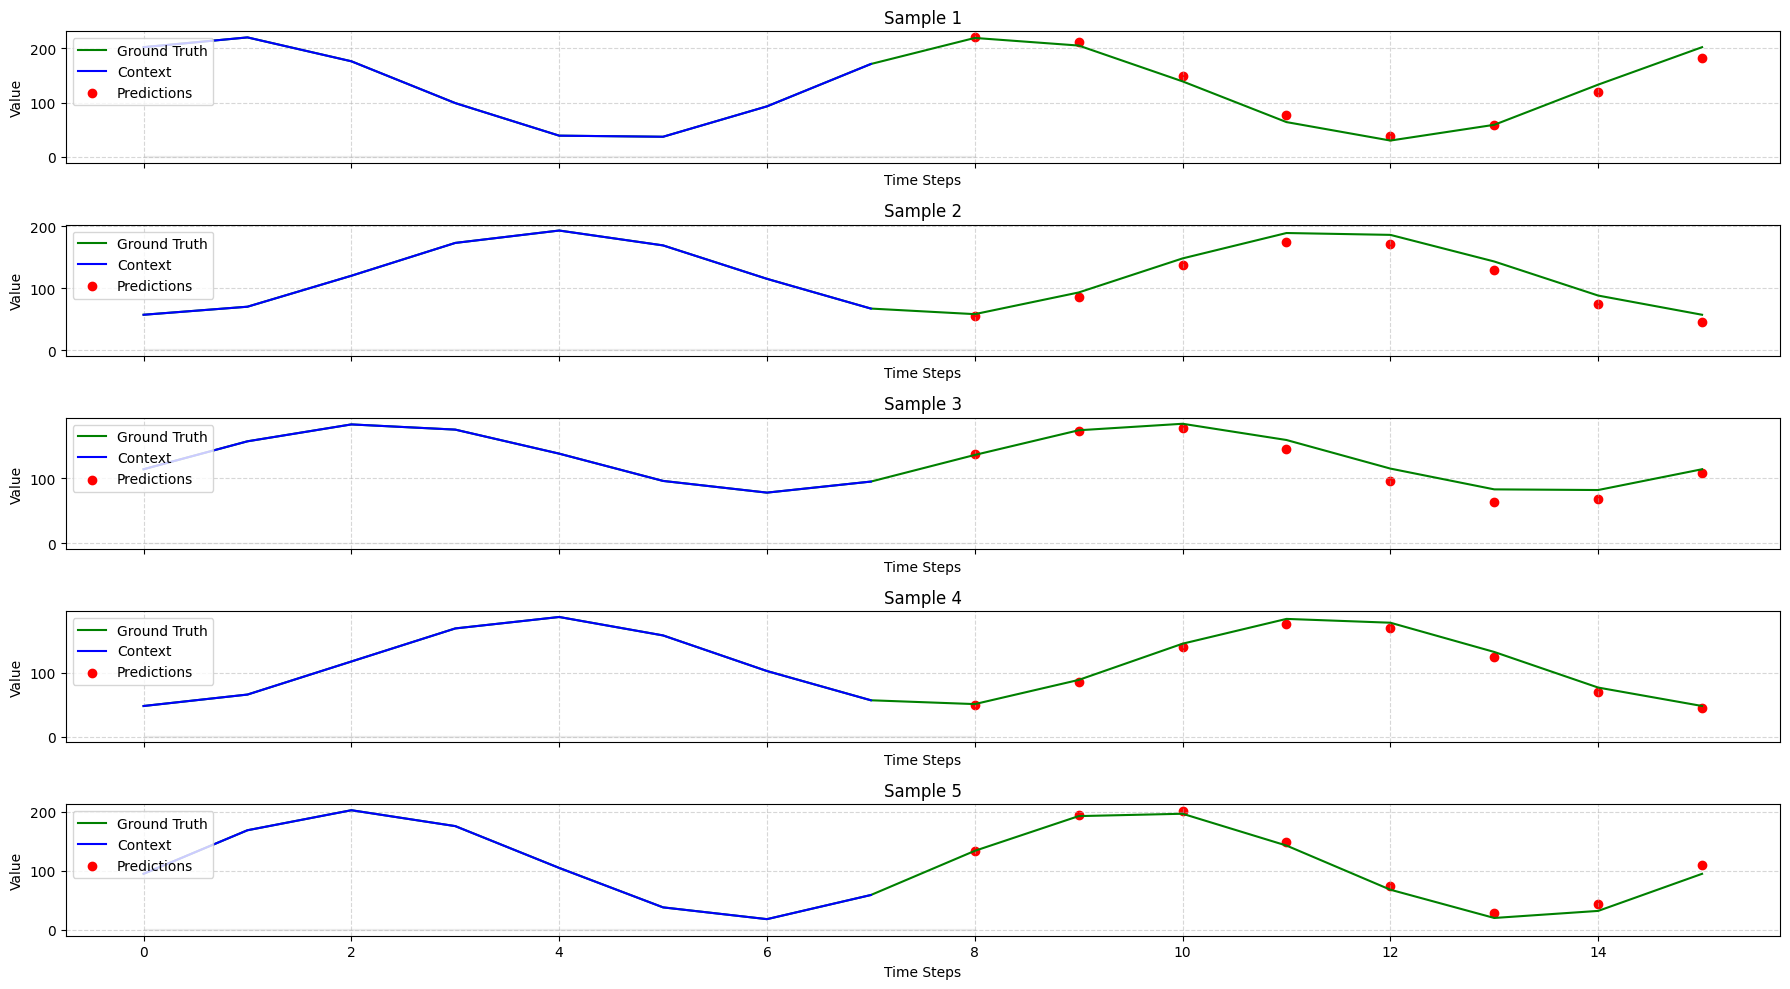

In [231]:
# Evaluate the models performance by plotting predictions
plot_predictions_with_context_shading(data, model, context_length=8, num_samples=5, device=device, fig_size=(18, 10))

In [234]:
# What happens when you decrease the context length. Use the above plot function to make an argument. Explain your observations.
# The model is unable to predict the sequence accurately when the context length is reduced. The predictions are less accurate and deviate more from the ground truth as the context length decreases. This is because the model has less information to base its predictions on, resulting in a less reliable forecast.

Context Length: 1


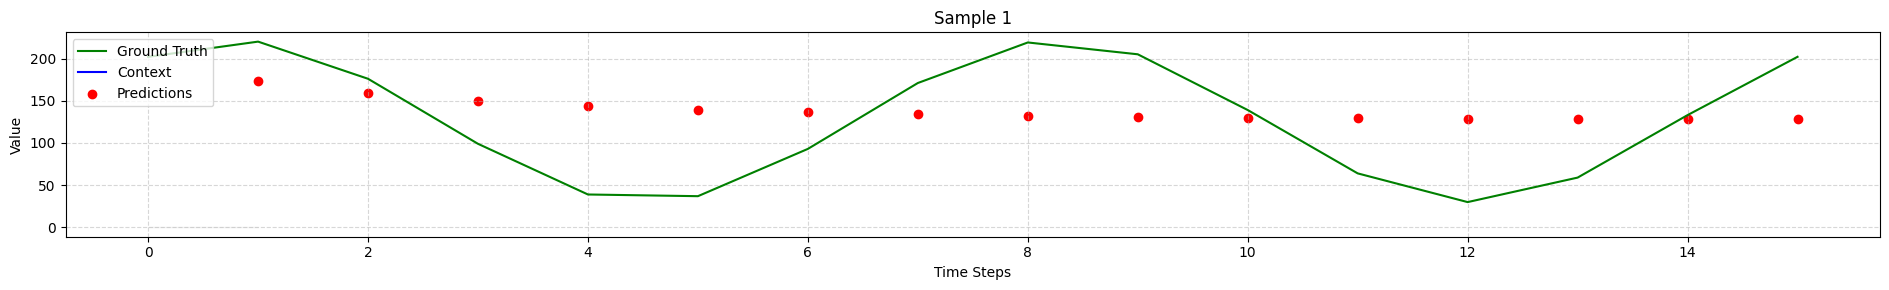

Context Length: 2


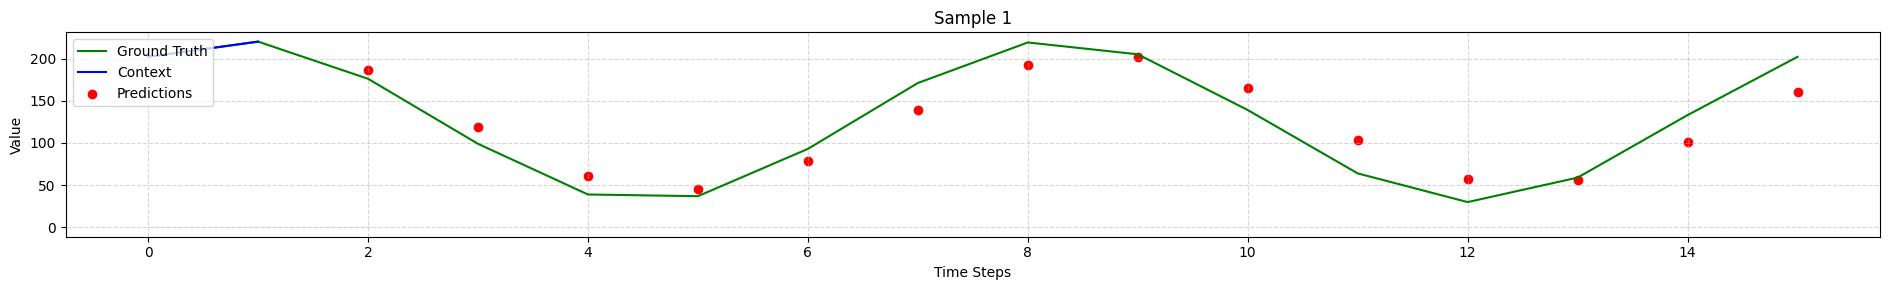

Context Length: 3


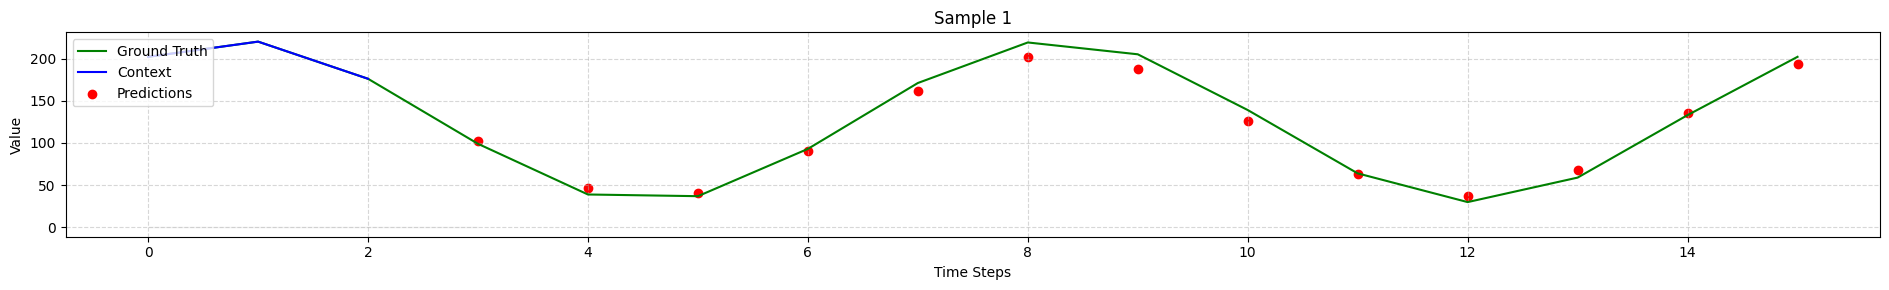

Context Length: 4


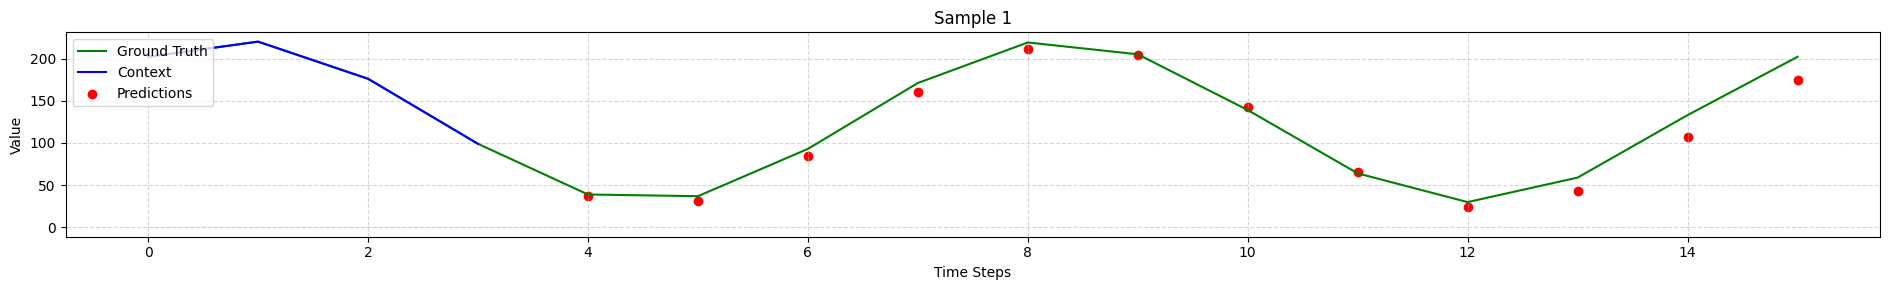

Context Length: 5


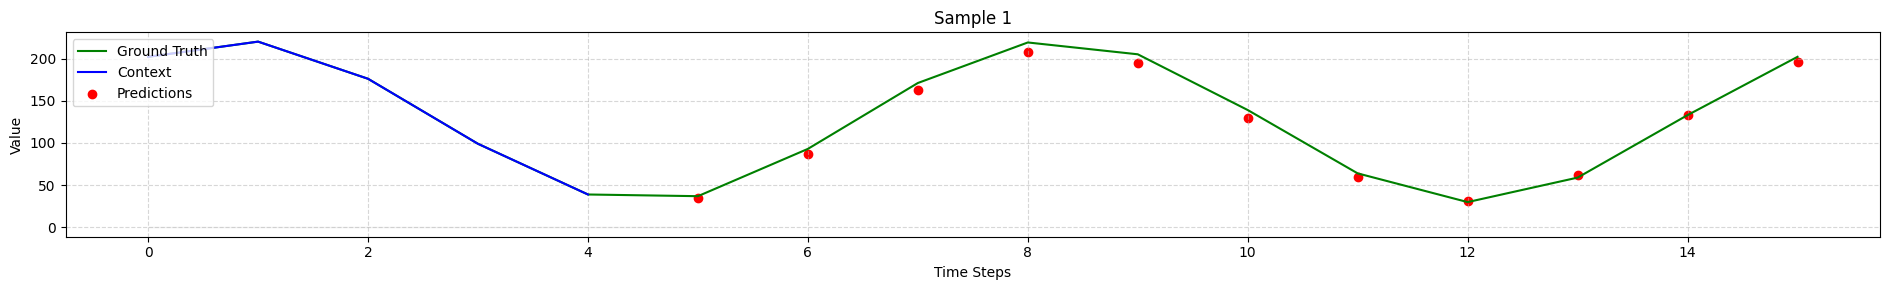

Context Length: 6


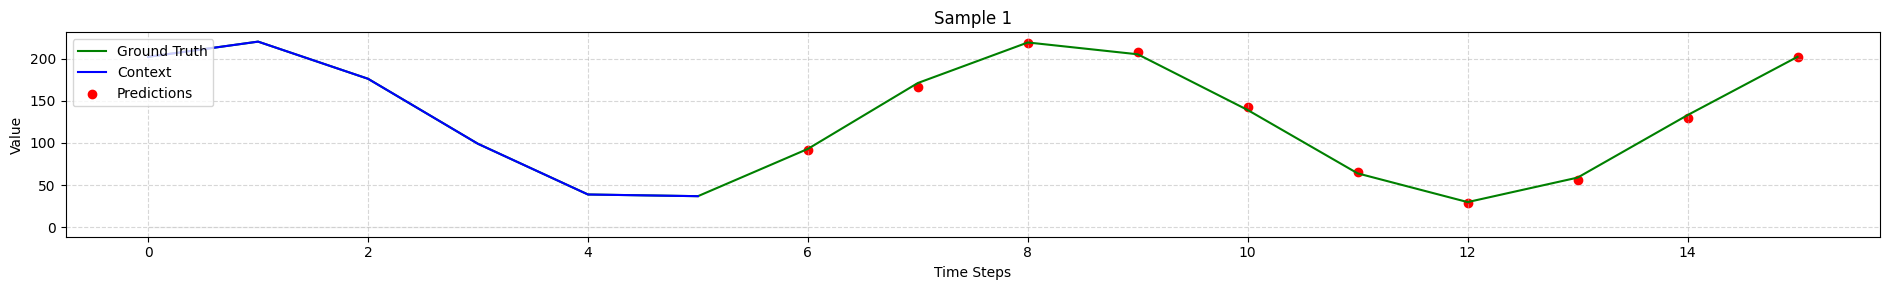

Context Length: 7


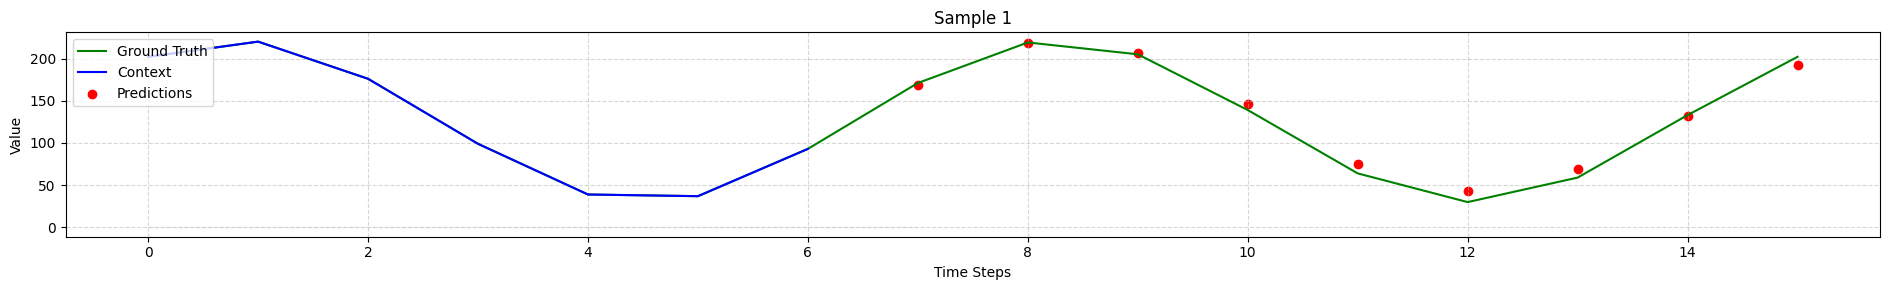

Context Length: 8


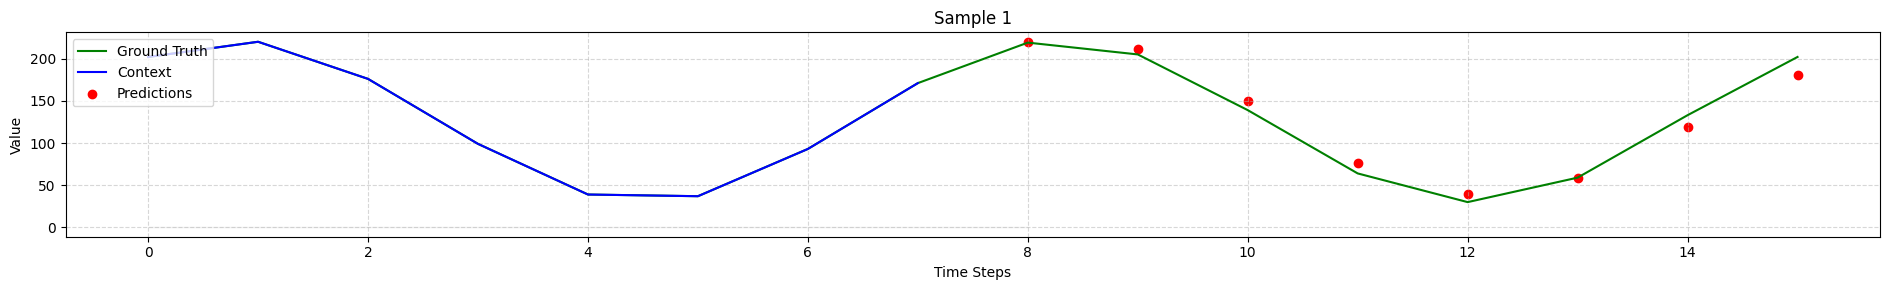

Context Length: 9


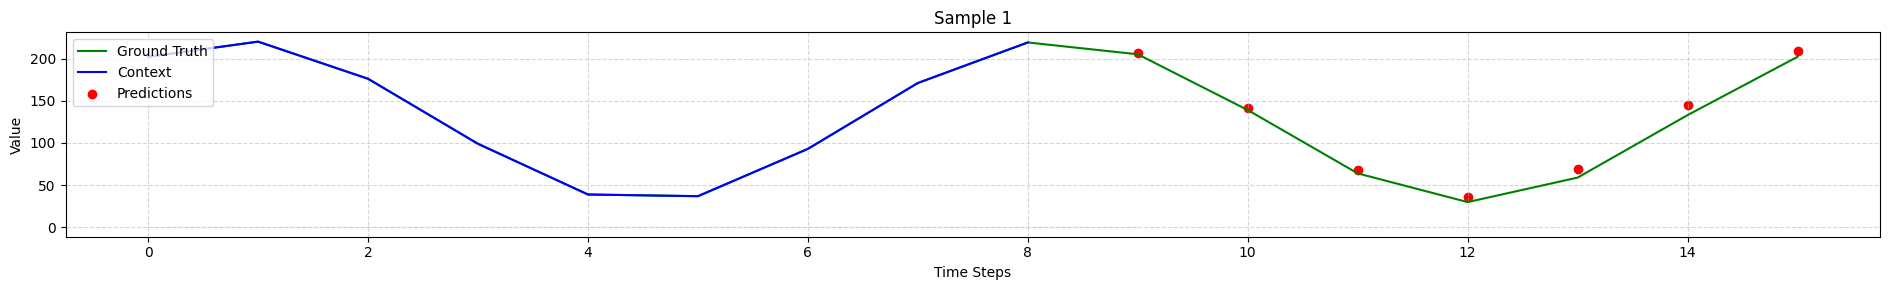

Context Length: 10


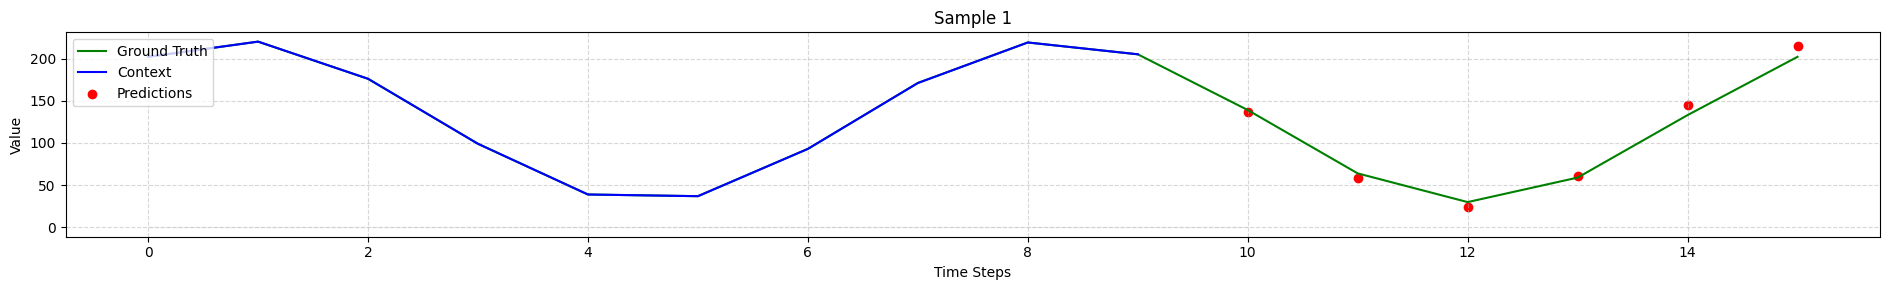

In [233]:
for i in range(1, 11):
    print(f"Context Length: {i}")
    plot_predictions_with_context_shading(data, model, context_length=i, num_samples=1, device=device, fig_size=(19, 3))